In [1]:
import torch
from tqdm import tqdm
from models import WrapperI3D
import pandas as pd
from milforvideo.video import Extractor, VideoFeature
from torchvision import transforms
from PIL import Image
import os
import cv2
import numpy as np


PATHLIST = "/datasets/UCSD_Anomaly_Dataset_v1p2/ped1_test.txt"

def open_image(path: str, resize: float = 1.0) -> Image.Image:
    assert os.path.exists(path)
    img = cv2.imread(path)
    return cv2.resize(img, dsize=None, fx=resize, fy=resize)
        

def get_mask_path(path):
    TXT = "Test000/000.tif"
    return path[:-len(TXT)] + path[-len(TXT):-len("Test000") - 1] + "_gt/" + os.path.basename(path).replace(".tif", ".bmp")

def open_mask(path: str, resize: float = 1.0) -> Image.Image:
    mask_path = get_mask_path(path)
    if os.path.exists(mask_path):
        return open_image(mask_path, resize)
    else:
        return np.zeros(open_image(path, resize).shape, dtype=np.uint8)

def img2tensor(paths, background, reverse_mask):    
    filter_value = 0 if reverse_mask else 255  
    return torch.stack([
        torch.tensor(np.where(
            open_mask(path) == filter_value, 
            open_image(path), 
            background))
        for path in paths
    ])

# def img2tensor(paths, background, reverse_mask):
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
    
#     # マスクを反転適用
#     filter_value = 0 if reverse_mask else 255
    
#     return torch.stack([
#         transform(Image.fromarray(np.where(
#             open_mask(path) == filter_value, 
#             open_image(path), 
#             background)))
#         for path in paths
#     ])


In [2]:

with open(PATHLIST) as f:
    grp_path_and_label = [
        row.split(" ")
        for row in f.read().split("\n")
        if row
    ]
    df = pd.DataFrame({
        "grp": [int(grp) for grp, _, _ in grp_path_and_label],
        "path": [path for _, path, _ in grp_path_and_label],
        "label": [int(label) for _, _, label in grp_path_and_label],
    })

IDX = 31
net = WrapperI3D()
idx, df_grp = list(df.groupby('grp'))[IDX]
background = np.median([
    open_image(path)
    for path in df_grp["path"].tolist()
], axis=0).astype(np.uint8)
extractor_mask = Extractor(
    df_grp["path"].tolist(), 
    df_grp["label"].tolist(), 
    net, lambda paths: img2tensor(paths, background, reverse_mask=False),
    F=16,
    aggregate=max,
    cuda=True)

extractor_mask.images().path_list[:5]

[['/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/001.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/002.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/003.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/004.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/005.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/006.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/007.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/008.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/009.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/010.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/011.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/012.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/013.tif',
  '/datasets/UCSD_Anomaly_Dataset_v1p2/UCSDped1/Test/Test032/014.tif',
  '/da

In [3]:
extractor_mask.images().__getitem__(0).size()

torch.Size([16, 158, 238, 3])

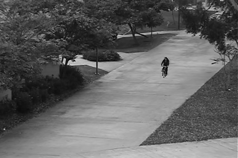

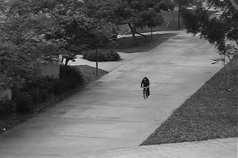

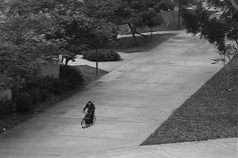

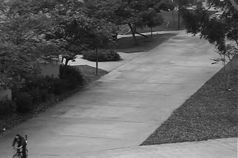

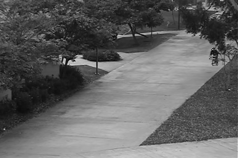

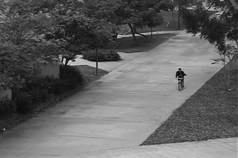

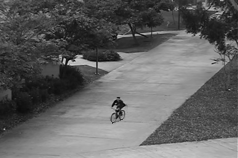

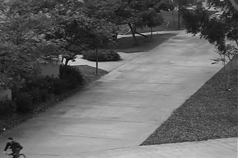

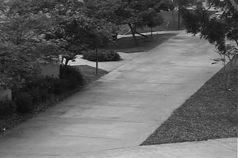

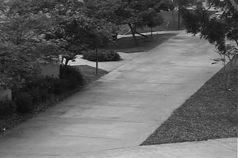

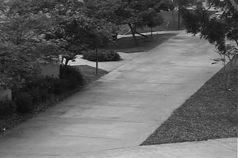

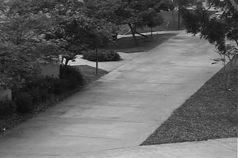

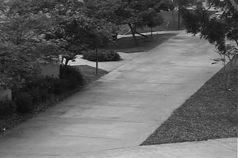

In [4]:
for idx in range(extractor_mask.images().__len__()):
    display(Image.fromarray(extractor_mask.images().__getitem__(idx)[0].numpy()))

In [5]:
# extractor_mask.extract().labels